In [1]:
import glob
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import numpy as np
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, MaxPooling2D, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
import keras.backend as K
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
!tar -xvf cifar-10-python.tar

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
cifar_data = []
for file in glob.glob("cifar-10-batches-py/data_batch_*"):
  batch = unpickle(file)
  cifar_data.append(batch)

In [9]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [22]:
class cifar_cnn():
  
  def __init__(self):
    self.img_shape = (32, 32, 3)
    self.epochs = 30
    
    
    
    self.model = self.build_cnn_model()
    self.model.compile('RMSProp', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    
  def build_cnn_model(self):
    img = Input(shape = self.img_shape)
    
    inception1 = Conv2D(32, kernel_size=1, strides=1, input_shape=self.img_shape, padding = 'same')(img)
    hid1 = LeakyReLU()(inception1)
    hid1 = MaxPooling2D((2,2))(hid1)
    hid1 = Dropout(0.2)(hid1)
    hid1 = BatchNormalization()(hid1)
    print(hid1)
    
    inception2 = Conv2D(32, kernel_size=3, strides=1, input_shape=self.img_shape, padding = 'same')(img)
    hid2 = LeakyReLU()(inception2)
    hid2 = MaxPooling2D((2,2))(hid2)
    hid2 = Dropout(0.2)(hid2)
    hid2 = BatchNormalization()(hid2)
    print(hid2)
    
    inception3 = Conv2D(32, kernel_size=5, strides=1, input_shape=self.img_shape, padding = 'same')(img)
    hid3 = LeakyReLU()(inception3)
    hid3 = MaxPooling2D((2,2))(hid3)
    hid3 = Dropout(0.2)(hid3)
    hid3 = BatchNormalization()(hid3)
    print(hid3)
    

    
    hid = Concatenate()([hid1, hid2, hid3])
    print(hid)
    hid = Conv2D(64, kernel_size=1, strides=1, padding = 'same')(hid)
    hid = LeakyReLU()(hid)
    hid = MaxPooling2D((2,2))(hid)
    hid = Dropout(0.2)(hid)
    hid = BatchNormalization()(hid)
    
    hid = Conv2D(128, kernel_size=3, strides=1, padding = 'same')(hid)
    hid = LeakyReLU()(hid)
    hid = MaxPooling2D((2,2))(hid)
    hid = Dropout(0.2)(hid)
    hid = BatchNormalization()(hid)
    
    
    hid = Flatten()(hid)
    hid = Dropout(0.2)(hid)
    
    validity = Dense(10, activation="softmax")(hid)

    return Model(img, validity)
  
  def train(self, x_train, y_train, x_val, y_val):
    
    history = self.model.fit(x_train,y_train,
                             epochs = self.epochs,
                             validation_data = (x_val, y_val))
    self.plot_progress(history)
    
  def plot_progress(self, history):
      history_dict = history.history
      accuracy = history_dict['accuracy']
      val_accuracy = history_dict['val_accuracy']
      loss = history_dict['loss']
      val_loss = history_dict['val_loss']

      fig = plt.figure(figsize=(15,7))
      plt.subplot(1,2,1)
      plt.plot(range(self.epochs), accuracy, 'r', label = 'Train Accuracy')
      plt.plot(range(self.epochs), val_accuracy, 'b', label = 'Validation Accuracy')
      plt.legend()

      plt.subplot(1,2,2)
      plt.plot(range(self.epochs), loss, 'r', label = 'Train Loss')
      plt.plot(range(self.epochs), val_loss, 'b', label = 'Validation Loss')

      plt.legend()
      plt.show()

    
    

In [20]:
cifar = cifar_cnn()

Tensor("batch_normalization_11/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("batch_normalization_12/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("batch_normalization_13/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 16, 16, 96), dtype=float32)


Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 247s 6ms/step - loss: 1.6790 - accuracy: 0.4407 - val_loss: 1.3579 - val_accuracy: 0.5177
Epoch 2/30
40000/40000 [==============================] - 231s 6ms/step - loss: 1.2223 - accuracy: 0.5757 - val_loss: 1.0952 - val_accuracy: 0.6106
Epoch 3/30
40000/40000 [==============================] - 240s 6ms/step - loss: 1.0616 - accuracy: 0.6321 - val_loss: 1.0704 - val_accuracy: 0.6285
Epoch 4/30
40000/40000 [==============================] - 231s 6ms/step - loss: 0.9800 - accuracy: 0.6606 - val_loss: 0.8947 - val_accuracy: 0.6870
Epoch 5/30
40000/40000 [==============================] - 230s 6ms/step - loss: 0.9086 - accuracy: 0.6848 - val_loss: 0.9301 - val_accuracy: 0.6782
Epoch 6/30
40000/40000 [==============================] - 230s 6ms/step - loss: 0.8713 - accuracy: 0.6988 - val_loss: 1.2288 - val_accuracy: 0.6051
Epoch 7/30
40000/40000 [==============================] - 242s

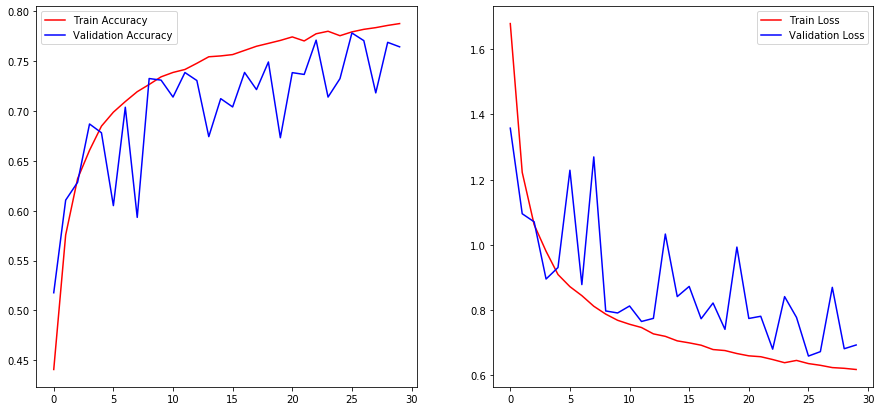

In [23]:
cifar.train(x_train, y_train, x_val, y_val)

In [24]:
 cifar.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 32)   128         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   2432        input_3[0][0]                    
____________________________________________________________________________________________

In [25]:
class cifar_residual_cnn():
  
  def __init__(self):
    self.img_shape = (32, 32, 3)
    self.epochs = 30
    
    
    
    self.model = self.build_cnn_model()
    self.model.compile('RMSProp', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    
  def build_cnn_model(self):
    img = Input(shape = self.img_shape)
    
    x = Conv2D(32, kernel_size=3, strides=1, input_shape=self.img_shape, padding = 'same')(img)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    hid1 = Conv2D(32, kernel_size=3, strides=1, input_shape=self.img_shape, padding = 'same')(x)
    hid1 = LeakyReLU()(hid1)
    #hid1 = MaxPooling2D((2,2))(hid1)
    hid1 = Dropout(0.2)(hid1)
    hid1 = BatchNormalization()(hid1)
    
    print(hid1)
    res1 = Add()([hid1, x])
    print(res1)
    
    
    y = Conv2D(64, kernel_size=3, strides=1, padding = 'same')(res1)
    y = LeakyReLU()(y)
    y = MaxPooling2D((2,2))(y)
    y = Dropout(0.2)(y)
    y = BatchNormalization()(y)
    
    hid2 = Conv2D(64, kernel_size=3, strides=1, padding = 'same')(y)
    hid2 = LeakyReLU()(hid2)
    #hid2 = MaxPooling2D((2,2))(hid2)
    hid2 = Dropout(0.2)(hid2)
    hid2 = BatchNormalization()(hid2)
    
    res2 = Add()([hid2, y])
    
    hid2 = Conv2D(64, kernel_size=3, strides=1, padding = 'same')(res2)
    hid2 = LeakyReLU()(hid2)
    #hid2 = MaxPooling2D((2,2))(hid2)
    hid2 = Dropout(0.2)(hid2)
    hid2 = BatchNormalization()(hid2)
    
    
    
    hid = Flatten()(hid2)
    hid = Dropout(0.2)(hid)
    
    validity = Dense(10, activation="softmax")(hid)

    return Model(img, validity)
  
  def train(self, x_train, y_train, x_val, y_val):
    
    history = self.model.fit(x_train,y_train,
                             epochs = self.epochs,
                             validation_data = (x_val, y_val))
    self.plot_progress(history)
    
  def plot_progress(self, history):
      history_dict = history.history
      accuracy = history_dict['accuracy']
      val_accuracy = history_dict['val_accuracy']
      loss = history_dict['loss']
      val_loss = history_dict['val_loss']

      fig = plt.figure(figsize=(15,7))
      plt.subplot(1,2,1)
      plt.plot(range(self.epochs), accuracy, 'r', label = 'Train Accuracy')
      plt.plot(range(self.epochs), val_accuracy, 'b', label = 'Validation Accuracy')
      plt.legend()

      plt.subplot(1,2,2)
      plt.plot(range(self.epochs), loss, 'r', label = 'Train Loss')
      plt.plot(range(self.epochs), val_loss, 'b', label = 'Validation Loss')

      plt.legend()
      plt.show()

    
    

In [26]:
res1 = cifar_residual_cnn()

Tensor("batch_normalization_17/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("add_3/add:0", shape=(?, 16, 16, 32), dtype=float32)


Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 231s 6ms/step - loss: 1.7372 - accuracy: 0.4487 - val_loss: 1.4103 - val_accuracy: 0.5350
Epoch 2/30
40000/40000 [==============================] - 224s 6ms/step - loss: 1.1864 - accuracy: 0.5926 - val_loss: 1.4310 - val_accuracy: 0.5089
Epoch 3/30
40000/40000 [==============================] - 223s 6ms/step - loss: 1.0179 - accuracy: 0.6450 - val_loss: 1.1127 - val_accuracy: 0.6036
Epoch 4/30
40000/40000 [==============================] - 221s 6ms/step - loss: 0.9296 - accuracy: 0.6762 - val_loss: 1.3425 - val_accuracy: 0.5672
Epoch 5/30
40000/40000 [==============================] - 226s 6ms/step - loss: 0.8711 - accuracy: 0.6955 - val_loss: 0.9480 - val_accuracy: 0.6706
Epoch 6/30
40000/40000 [==============================] - 222s 6ms/step - loss: 0.8298 - accuracy: 0.7120 - val_loss: 0.9669 - val_accuracy: 0.6718
Epoch 7/30
40000/40000 [==============================] - 220s

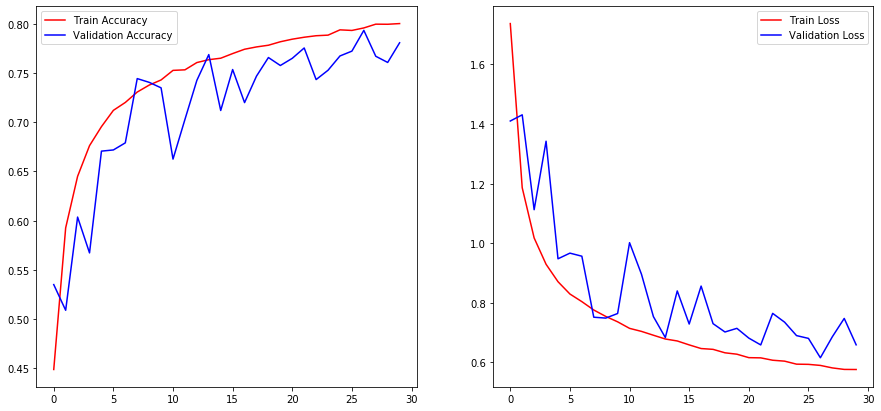

In [27]:
res1.train(x_train, y_train, x_val, y_val)